## The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Assignment 2

**Student Name:**    Einon McGrory-Perich

**Student ID:**     992697

## This iPython notebook is a template which you should use for your Assignment 2 submission. This file should be submitted at the **Assignment 2: Code** link on the LMS.

In addition to this file, you should submit a written report explaining your results at the **Assignment 2: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 1. CNN implementation

In this problem, you will implement a CNN to classify the yoga32 dataset. The following code section will load the dataset from a folder that you specify. You may change the batch sizes and validation percentage if you wish, but otherwise it is recommended that you do not modify this section.

In [150]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import secrets

data_dir = './yoga32'
train_batch_size = 32
rand_seed = 992697 # Use student ID for seed for repeatability during results 
# note that same seed must be used for both to ensure no overlap in train/val data

# Get training images from 'train' directory
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir+'/train',
    validation_split=0.2,
    subset="training",
    seed=rand_seed,
    image_size=(32, 32),
    batch_size=train_batch_size)

# Get validation images from 'train' directory
val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir+'/train',
    validation_split=0.2,
    subset="validation",
    seed=rand_seed,
    image_size=(32, 32),
    batch_size=train_batch_size)

# Get test images 
test_data = tf.keras.utils.image_dataset_from_directory(
    data_dir+'/test',
    image_size=(32, 32))


# Output list of class names
class_names = train_data.class_names
print(class_names)


# Normalise each image between 0 and 1
def normalize(image, label):
    return image / 255.0, label

train_data = train_data.map(normalize)
test_data = test_data.map(normalize)
val_data = val_data.map(normalize)

# Specify epochs to run for
num_epochs = 30



2.7.0
Found 520 files belonging to 10 classes.
Using 416 files for training.
Found 520 files belonging to 10 classes.
Using 104 files for validation.
Found 70 files belonging to 10 classes.
['bridge', 'childs', 'downwarddog', 'mountain', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']


1.1. Implement the CNN shown in the assignment specification and train it on the provided dataset. Plot the training accuracy and validation accuracy over epochs.

In [151]:
# Train a base model following the specification 
mlp = keras.Sequential(
[
    layers.Input((32,32,3)),
    layers.Conv2D(
        filters=16,
        kernel_size=(3,3),
        strides=(1,1),
        padding="valid",
        activation="relu"
    ),
    layers.Conv2D(
        filters=16,
        kernel_size=(3,3),
        strides=(1,1),
        padding="valid",
        activation="relu"
    ),
    layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2),
        padding="valid"
    ),
    layers.Conv2D(
        filters=24,
        kernel_size=(3,3),
        strides=(1,1),
        padding="valid",
        activation="relu"
    ),
    layers.Conv2D(
        filters=24,
        kernel_size=(3,3),
        strides=(1,1),
        padding="valid",
        activation="relu"
    ),
    layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2),
        padding="valid"
    ),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

mlp.compile(optimizer='adam',
           loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
           metrics=['accuracy'])

history_mlp = mlp.fit(train_data, validation_data=val_data, epochs=num_epochs)



Epoch 1/30
13/13 [==============================] - 1s 19ms/step - loss: 2.3051 - accuracy: 0.0913 - val_loss: 2.3077 - val_accuracy: 0.1346
Epoch 2/30
13/13 [==============================] - 0s 14ms/step - loss: 2.2878 - accuracy: 0.1683 - val_loss: 2.2892 - val_accuracy: 0.1154
Epoch 3/30
13/13 [==============================] - 0s 14ms/step - loss: 2.2425 - accuracy: 0.1611 - val_loss: 2.2204 - val_accuracy: 0.1442
Epoch 4/30
13/13 [==============================] - 0s 14ms/step - loss: 2.0679 - accuracy: 0.2572 - val_loss: 1.9949 - val_accuracy: 0.2596
Epoch 5/30
13/13 [==============================] - 0s 14ms/step - loss: 1.8272 - accuracy: 0.3630 - val_loss: 1.9358 - val_accuracy: 0.2981
Epoch 6/30
13/13 [==============================] - 0s 14ms/step - loss: 1.6790 - accuracy: 0.4159 - val_loss: 1.7936 - val_accuracy: 0.3750
Epoch 7/30
13/13 [==============================] - 0s 14ms/step - loss: 1.5566 - accuracy: 0.4543 - val_loss: 1.7801 - val_accuracy: 0.3269
Epoch 8/30
13

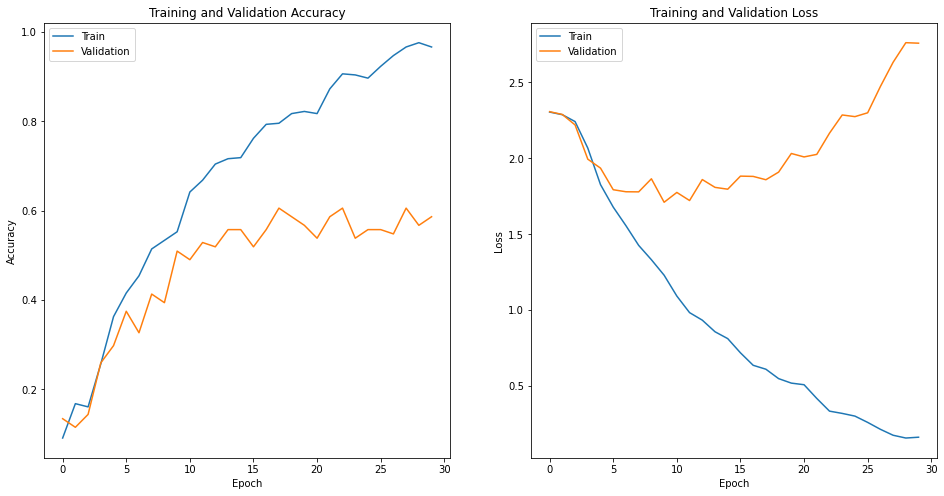

In [152]:
# Plot the learning curves 
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 1)
ax = plt.plot(history_mlp.history['accuracy'], label='Train')
ax = plt.plot(history_mlp.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax = plt.plot(history_mlp.history['loss'], label='Train')
ax = plt.plot(history_mlp.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('base_learning.png')

1.2. Modify the CNN (see assignment spec for details) and train it on the provided dataset.  Plot the training accuracy and validation accuracy over epochs.

In [153]:
# Create the augmenting layer
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(mode="horizontal"),
        layers.RandomContrast(factor=0.2)
    ]
)

# Design the modified model to use regularization and augmentation
modified_mlp = keras.Sequential(
[
    
    layers.Input((32,32,3)),
    data_augmentation,
    layers.Conv2D(
        filters=16,
        kernel_size=(3,3),
        strides=(1,1),
        padding="valid",
        activation="relu"
    ),
    layers.Conv2D(
        filters=16,
        kernel_size=(3,3),
        strides=(1,1),
        padding="valid",
        activation="relu"
    ),
    layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2),
        padding="valid"
    ),
    layers.Conv2D(
        filters=24,
        kernel_size=(3,3),
        strides=(1,1),
        padding="valid",
        activation="relu"
    ),
    layers.Conv2D(
        filters=24,
        kernel_size=(3,3),
        strides=(1,1),
        padding="valid",
        activation="relu", 
        kernel_regularizer=regularizers.L2(l2=0.02)
    ),
    layers.MaxPooling2D(
        pool_size=(2,2),
        strides=(2,2),
        padding="valid"
    ),
    layers.Flatten(),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.L2(l2=0.01))
])

modified_mlp.compile(optimizer='adam',
           loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
           metrics=['accuracy'])

modified_mlp_history = modified_mlp.fit(train_data, validation_data=val_data, epochs=num_epochs)


Epoch 1/30
13/13 [==============================] - 1s 24ms/step - loss: 2.9004 - accuracy: 0.1058 - val_loss: 2.8170 - val_accuracy: 0.0385
Epoch 2/30
13/13 [==============================] - 0s 18ms/step - loss: 2.7320 - accuracy: 0.1538 - val_loss: 2.6718 - val_accuracy: 0.1058
Epoch 3/30
13/13 [==============================] - 0s 15ms/step - loss: 2.5947 - accuracy: 0.1707 - val_loss: 2.5620 - val_accuracy: 0.1058
Epoch 4/30
13/13 [==============================] - 0s 15ms/step - loss: 2.4502 - accuracy: 0.1899 - val_loss: 2.3824 - val_accuracy: 0.1635
Epoch 5/30
13/13 [==============================] - 0s 15ms/step - loss: 2.1724 - accuracy: 0.3077 - val_loss: 2.0504 - val_accuracy: 0.2981
Epoch 6/30
13/13 [==============================] - 0s 18ms/step - loss: 2.0519 - accuracy: 0.3173 - val_loss: 1.9485 - val_accuracy: 0.3269
Epoch 7/30
13/13 [==============================] - 0s 15ms/step - loss: 1.8786 - accuracy: 0.3990 - val_loss: 1.9988 - val_accuracy: 0.3654
Epoch 8/30
13

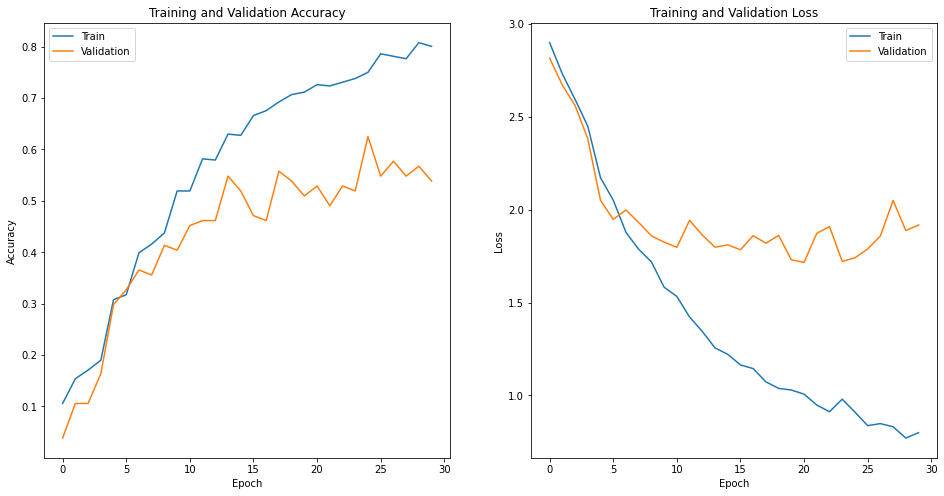

In [154]:
# Plot learning curves of modified model
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 1)
ax = plt.plot(modified_mlp_history.history['accuracy'], label='Train')
ax = plt.plot(modified_mlp_history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')
plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax = plt.plot(modified_mlp_history.history['loss'], label='Train')
ax = plt.plot(modified_mlp_history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('modified_learning.png')

### 2. Error anaylsis
Evaluate your CNN model from question 1.2 on the test dataset. See assignment spec for details.

In [155]:
# Evaluate both models on test data 
results = mlp.evaluate(test_data)
results = modified_mlp.evaluate(test_data)

# Identify classification performances for each class
test_predictions = []
test_labels = []

# Required to store all the data in one dimension to get performance measurements
for element in test_data.as_numpy_iterator():
    predictions = modified_mlp.predict(element[0])   
    
    test_predictions = np.concatenate((test_predictions, np.argmax(predictions, axis=-1)))
    test_labels = np.concatenate((test_labels, element[1]))
    
test_labels = test_labels.astype('int')
test_predictions = test_predictions.astype('int')

# Use confusion matrix to get individual accuracies
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(test_labels, test_predictions, labels=[0,1,2,3,4,5,6,7,8,9])
results = matrix.diagonal()/matrix.sum(axis=1)


for i in range(len(class_names)):
    print(f'{class_names[i].capitalize()} {results[i]*100:.2f}%')
        


3/3 [==============================] - 0s 4ms/step - loss: 1.9347 - accuracy: 0.6143
Bridge 71.43%
Childs 42.86%
Downwarddog 71.43%
Mountain 100.00%
Plank 42.86%
Seatedforwardbend 71.43%
Tree 28.57%
Trianglepose 71.43%
Warrior1 57.14%
Warrior2 57.14%


In [156]:
# Run following sections after this one.
# Used in Q2 to label and produce the image

# image_num = 25

# def get_image(image_num):
#     image1 = test_images[image_num]
#     image1_expanded = np.expand_dims(image1, axis=0)
#     actual_label = class_names[test_labels_pt3[image_num]]

#     predicted = modified_mlp.predict(image1_expanded)
#     predicted_label_pt2 = class_names[np.argmax(predicted)]

#     return image1, actual_label, predicted_label_pt2, np.max(predicted)


# im1, act1, pred1, conf1  = get_image(21)

# ax = plt.imshow(im1)
# plt.title(f"Actual: {act1}, Predicted: {pred1}, Confidence: {conf1:.2f}")
# plt.axis('off')


### 3. Visualisation

Visualise the feature space that your model uses to classify images. See assignment spec for details.

In [157]:
# This section extracts all of the feature information for every image in this system
# It may take a while to run

# Create Model object so individual layers can be observed
layer_outputs = [layer.output for layer in modified_mlp.layers[1:9]]  
activation_model = Model(inputs=modified_mlp.input, outputs=layer_outputs)

layer_names = []
for layer in modified_mlp.layers[1:9]:
    layer_names.append(layer.name)    
    
# Store all test data activations into an array, and record the image and label that came with it
test_data_activations = []
test_images = []
test_labels_pt3 = []
predicted_label = []

# Store in one dimensional array for easy distance calculations
for element in test_data.as_numpy_iterator():
    # Values for each layer
    images = element[0]
    for i in range(0,len(images)):
        image = np.expand_dims(images[i], axis=0)
        prediction = activation_model.predict(image)  
        
        # Second last layer is maxpool output
        flatten_activations = prediction[-2]
        test_data_activations.append(flatten_activations)
        test_images.append(images[i])
        test_labels_pt3.append(element[1][i])
        predicted_label.append(class_names[np.argmax(prediction[-1], axis=-1)[0]])

# Store all train data activations into an array, and record the image and label that came with it
train_data_activations = []
train_images = []
train_labels = []
        
for element in train_data.as_numpy_iterator():
    # Values for each layer
    images = element[0]
    for i in range(0,len(images)):
        image = np.expand_dims(images[i], axis=0)
        prediction = activation_model.predict(image)  
        
        flatten_activations = prediction[-2]
        train_data_activations.append(flatten_activations)
        train_images.append(images[i])
        train_labels.append(element[1][i])

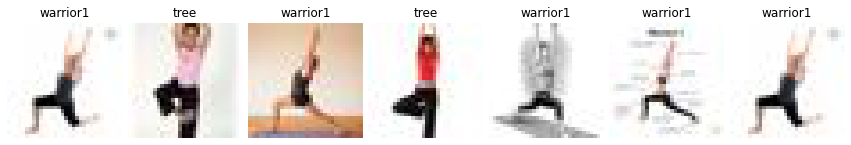

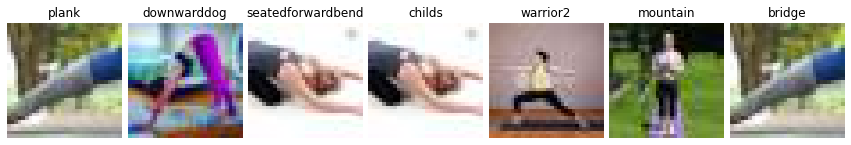

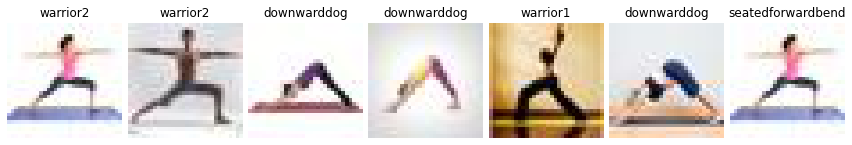

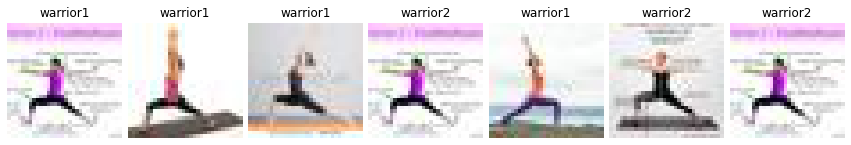

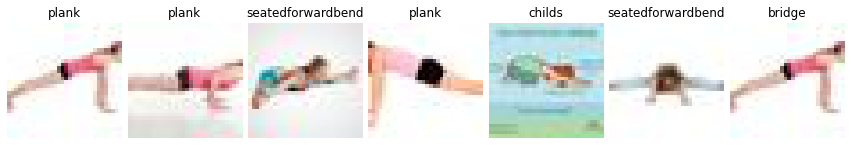

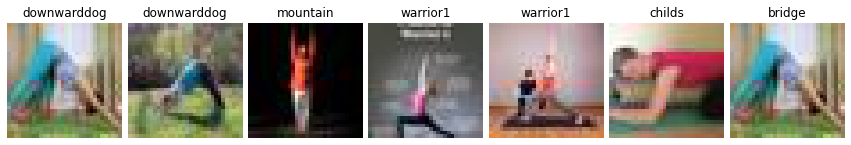

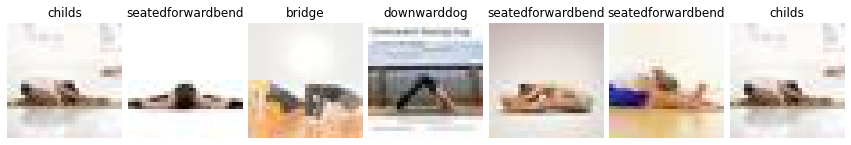

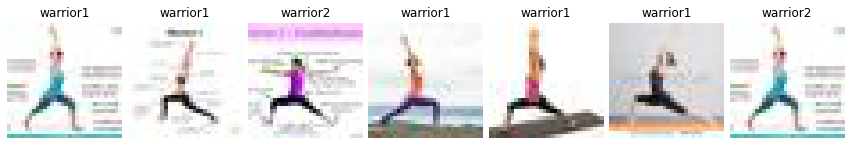

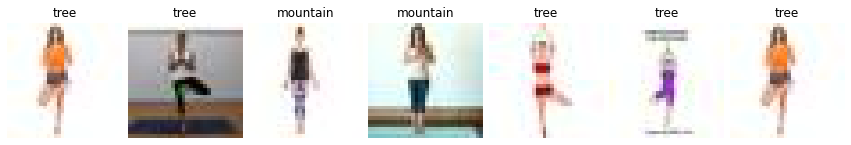

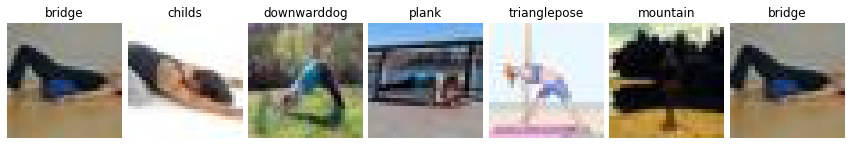

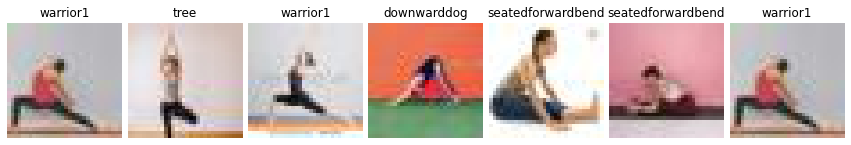

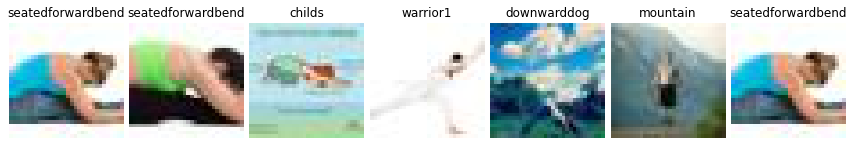

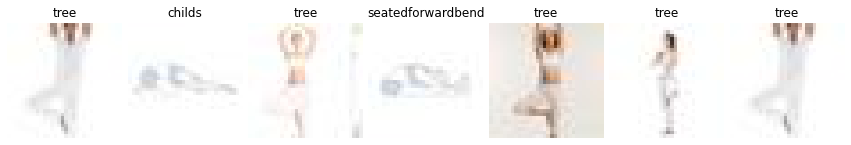

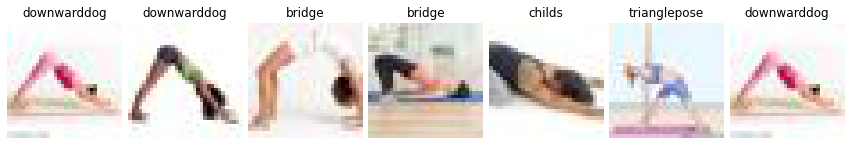

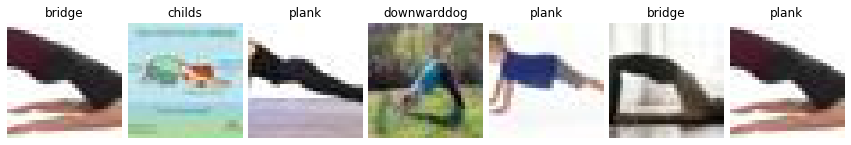

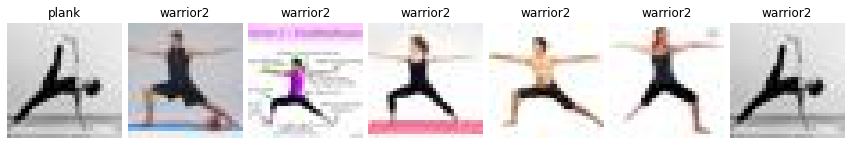

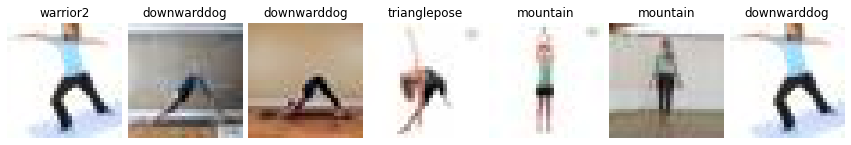

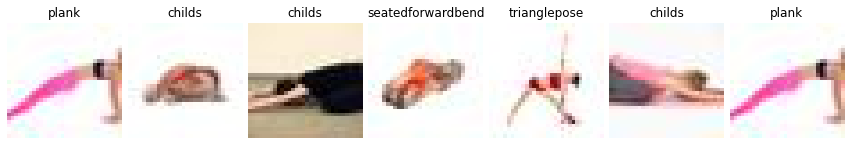

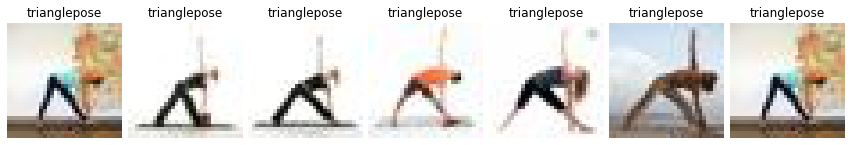

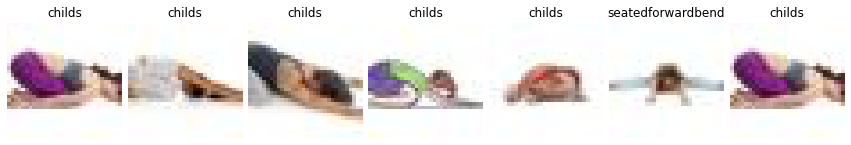

In [158]:
# This will calculate euclidean distances between every test image and train image, and store them 

test_to_train_distances = []

# Store distance between each test and train image
for test_activation in test_data_activations:
    test_distances = []
    for train_activation in train_data_activations:
        dist = np.linalg.norm(test_activation-train_activation)
        test_distances.append(dist)
    test_to_train_distances.append(test_distances)
        
        
neighbour_indexes = []

# Select the 5 smallest euclidean distances and store them
for distance in test_to_train_distances:
    neighbour_indexes.append(list(np.argpartition(distance, 5)[:5]))
    
# Modify to print for all images
# First is test, next 5 are training images
for image_choice in range(0,20):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(1, 7, 1)
    ax = plt.imshow(test_images[image_choice])
    plt.title(class_names[test_labels_pt3[image_choice]])
    plt.axis('off')
    fig.subplots_adjust(wspace=0.05, hspace=0.5)

    for img in range(0,5):
        ax = fig.add_subplot(1, 7, img+2)
        ax = plt.imshow(train_images[neighbour_indexes[image_choice][img]])
        plt.title(class_names[train_labels[neighbour_indexes[image_choice][img]]])
        plt.axis('off')
        fig.subplots_adjust(wspace=0.1, hspace=0.5)
    ax = fig.add_subplot(1, 7, 7)
    ax = plt.imshow(test_images[image_choice])
    plt.title(predicted_label[image_choice])
    fig.subplots_adjust(wspace=0.05, hspace=0.5)
    plt.axis('off')


